In [ ]:
https://archive.ics.uci.edu/ml/datasets/Iranian+Churn+Dataset
https://medium.com/@odury/customer-churn-prediction-with-no-code-data-science-odury-ed6b530ae336
https://www.kaggle.com/datasets/royjafari/customer-churn

In [1]:
!pip install lifelines
!pip install osqp==0.5
!pip install scikit-survival
!pip install pycox
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 349 kB 5.0 MB/s 
     |████████████████████████████████| 68 kB 7.6 MB/s 
     |████████████████████████████████| 38.1 MB 1.1 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=15471248c56bf52b64863a32d2414a6a1f572b7e979eb4ab66d30d6d081ad2db
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as opt
from torch.distributions.weibull import Weibull
from torch.distributions.log_normal import LogNormal
from torch.distributions.categorical import Categorical
from torch.distributions.mixture_same_family import MixtureSameFamily
from einops import rearrange
import pandas as pd
import numpy as np
import scipy.stats as ss
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lifelines.utils import concordance_index# as c_index
from sksurv.metrics import brier_score, integrated_brier_score, concordance_index_censored as ci_scikit
from copy import copy, deepcopy
import dask
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark = True

Mounted at /content/drive


In [2]:
def non_censored_diagn(data, E, T, mlt, step):
    errors, churned = [], np.where(E)[0]
    bins = np.arange(min(T.iloc[churned]), max(T.iloc[churned]), step)
    for i in range(len(bins)-1):
        idx = data_test.loc[(data[event_column]==1) & (data[time_column]>=bins[i]) & (data[time_column]<=bins[i+1])].index.values
        errors.append(mean_absolute_error(T_test.iloc[idx], mlt[idx]))
    fig = make_subplots(rows=3, cols=1)
    # Add traces
    fig.append_trace(go.Scatter(x=T.iloc[churned].index, y=T.iloc[churned], mode='markers', name='TRUE'), row=1, col=1)
    fig.append_trace(go.Scatter(x=T.iloc[churned].index, y=mlt[churned], mode='markers', name='PRED'), row=1, col=1)
    fig.append_trace(go.Scatter(x=T.iloc[churned].index, y=np.abs(T.iloc[churned] - mlt[churned]), mode='lines', name='ERROS'), row=1, col=1)
    fig.append_trace(go.Scatter(x=[0, max(T.iloc[churned].index)], y=[mean_absolute_error(T.iloc[churned], mlt[churned])]*2, mode='lines', name='MAE'), row=1, col=1)
    fig.append_trace(go.Scatter(x=[0, max(T.iloc[churned].index)], y=[np.median(np.abs(T.iloc[churned] - mlt[churned]))]*2, mode='lines', name='MEDIAN'), row=1, col=1)
    fig.append_trace(go.Histogram(x=np.abs(T.iloc[churned] - mlt[churned]), histnorm='probability'), row=2, col=1)
    fig.append_trace(go.Scatter(x=bins[1:], y=errors), row=3, col=1)
    fig.update_layout(height=750)
    return fig

def plot_surv(idx, T, mlt, surv, times):
    rows, cols, k = int(np.ceil(len(idx)/3)), 3, 0
    subplot_titles = ['Survival curve of '+str(c) for c in idx]
    surv_plot = make_subplots(rows=rows, cols=cols, shared_yaxes=True, subplot_titles=subplot_titles, horizontal_spacing = 0.01, vertical_spacing=0.05)
    for i in range(rows):
        for j in range(cols):
          surv_plot.add_trace(go.Scatter(x=times, y=surv[:,idx[k]].flatten(), name=str(idx[k]), line=dict(color='#0000ff')), row=i+1, col=j+1)
          surv_plot.add_trace(go.Scatter(x=[T[idx[k]]]*10, y=np.linspace(0,1,10), mode='lines', line=dict(color='#ff0000')), row=i + 1, col=j + 1)
          surv_plot.add_trace(go.Scatter(x=[mlt[idx[k]]] * 10, y=np.linspace(0, 1, 10), mode='lines', line=dict(color='#00ff00')), row=i + 1, col=j + 1)
          k += 1
          if k >= len(idx):
            break
    surv_plot.update_layout(height=rows*300)
    return surv_plot

In [3]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/survival analysis/iranian_telecom_churn/Customer Churn.csv')
df

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,FN,FP,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,177.8760,69.7640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,41.4315,60.0000,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,1382.8680,203.6520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,216.0180,74.0020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,131.2245,64.5805,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,21,0,19,2,6697,147,92,44,2,2,1,25,721.980,649.7820,122.1980,0
3146,17,0,17,1,9237,177,80,42,5,1,1,55,261.210,235.0890,76.1210,0
3147,13,0,18,4,3157,51,38,21,3,1,1,30,280.320,252.2880,78.0320,0
3148,7,0,11,2,4695,46,222,12,3,1,1,30,1077.640,969.8760,157.7640,0


In [ ]:
pd.DataFrame({'Dtype': df.dtypes, 'Nunique': df.nunique(), 'Isnull': df.isnull().sum()}, index=df.columns)

,Dtype,Nunique,Isnull
Call Failure,int64,37,0
Complains,int64,2,0
Subscription Length,int64,45,0
Charge Amount,int64,11,0
Seconds of Use,int64,1756,0
Frequency of use,int64,242,0
Frequency of SMS,int64,405,0
Distinct Called Numbers,int64,92,0
Age Group,int64,5,0
Tariff Plan,int64,2,0


In [ ]:
df.describe()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,FN,FP,Churn
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000
mean,7.627937,0.076508,32.541905,0.942857,4472.459683,69.460635,73.174921,23.509841,2.826032,1.077778,1.248254,30.998413,470.972916,423.875624,98.304688,0.157143
std,7.263886,0.265851,8.573482,1.521072,4197.908687,57.413308,112.237560,17.217337,0.892555,0.267864,0.432069,8.831095,517.015433,465.313890,50.724492,0.363993
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,15.000000,0.000000,0.000000,60.000000,0.000000
25%,1.000000,0.000000,30.000000,0.000000,1391.250000,27.000000,6.000000,10.000000,2.000000,1.000000,1.000000,25.000000,113.801250,102.421125,61.380125,0.000000
50%,6.000000,0.000000,35.000000,0.000000,2990.000000,54.000000,21.000000,21.000000,3.000000,1.000000,1.000000,30.000000,228.480000,205.632000,72.848000,0.000000
75%,12.000000,0.000000,38.000000,1.000000,6478.250000,95.000000,87.000000,34.000000,3.000000,1.000000,1.000000,30.000000,788.388750,709.549875,128.838875,0.000000
max,36.000000,1.000000,47.000000,10.000000,17090.000000,255.000000,522.000000,97.000000,5.000000,2.000000,2.000000,55.000000,2165.280000,1948.752000,266.528000,1.000000


In [4]:
time_column = 'Subscription  Length'
event_column = 'Churn'
to_remove = ['FN', 'FP']
categorical = []
binary = ['Complains', 'Status']
numerical = [col for col in df.columns if col not in to_remove + categorical + binary + [event_column] + [time_column]]
df[numerical] = df[numerical].apply(pd.to_numeric,1)
#df = df.replace({event_column: {'No': 0, 'Yes': 1}})
df[time_column] = df[time_column] + 1e-10
fig = go.Figure(data=go.Heatmap(z=df[numerical].corr(),x=numerical,y=numerical))
fig.show()

In [ ]:
df.columns

Index(['Call  Failure', 'Complains', 'Subscription  Length', 'Charge  Amount',
       'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Tariff Plan', 'Status', 'Age',
       'Customer Value', 'FN', 'FP', 'Churn'],
      dtype='object')

In [5]:
from sklearn.model_selection import train_test_split

OE = OneHotEncoder(drop='if_binary', sparse=False)
df[binary] = OE.fit_transform(df[binary]).astype(int)

corr_col = ['Frequency of use', 'Age Group']
numerical = [col for col in numerical if col not in corr_col]
features = categorical + numerical + binary

index_train, index_test = train_test_split(range(df.shape[0]), test_size=0.2, random_state=0, stratify=df[binary+categorical])
tmp_data_train = df.loc[index_train].reset_index( drop = True )
data_test  = df.loc[index_test].reset_index( drop = True )

index_train, index_valid = train_test_split(tmp_data_train.index, test_size=0.15, random_state=0, stratify=tmp_data_train[binary+categorical])
data_train = tmp_data_train.loc[index_train].reset_index( drop = True )
data_valid = tmp_data_train.loc[index_valid].reset_index( drop = True )

 
# Creating the X, T and E inputs
X_train, X_valid, X_test = data_train[features], data_valid[features], data_test[features]
T_train, T_valid, T_test = data_train[time_column], data_valid[time_column], data_test[time_column]
E_train, E_valid, E_test = data_train[event_column], data_valid[event_column], data_test[event_column]

cat_enc_d = {}
for cat in categorical:
    LE = LabelEncoder()
    X_train[cat] = LE.fit_transform(X_train[cat])
    X_valid[cat] = LE.transform(X_valid[cat])
    X_test[cat] = LE.transform(X_test[cat])
    cat_enc_d[cat] = LE
 
MS = MinMaxScaler(feature_range=(0, 1))
scaled_train = MS.fit_transform(X_train[numerical])
scaled_valid = MS.transform(X_valid[numerical])
scaled_test = MS.transform(X_test[numerical])
X_train[numerical], X_valid[numerical], X_test[numerical] = scaled_train, scaled_valid, scaled_test

X_train.shape, X_valid.shape, X_test.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



((2142, 10), (378, 10), (630, 10))

In [ ]:
X_train

,Call Failure,Charge Amount,Seconds of Use,Frequency of SMS,Distinct Called Numbers,Tariff Plan,Age,Customer Value,Complains,Status
0,0.055556,0.0,0.795819,0.000000,0.391753,0.0,0.375,0.252568,0,0
1,0.194444,0.0,0.131802,0.000000,0.164948,0.0,0.375,0.042230,1,1
2,0.416667,0.1,0.090106,0.049808,0.154639,0.0,0.250,0.086622,0,0
3,0.444444,0.0,0.059187,0.032567,0.092784,0.0,0.375,0.050543,0,1
4,0.250000,0.1,0.193463,0.877395,0.061856,0.0,0.375,0.907264,0,0
...,...,...,...,...,...,...,...,...,...,...
2137,0.194444,0.1,0.209069,0.067050,0.309278,0.0,0.375,0.131678,0,0
2138,0.388889,0.3,0.215548,0.967433,0.164948,0.0,0.750,0.625820,0,0
2139,0.444444,0.1,0.289046,0.017241,0.360825,0.0,0.000,0.149484,0,0
2140,0.000000,0.0,0.428916,0.741379,0.463918,0.0,0.250,0.958199,0,0


In [6]:
from torch import autograd
 
class SURV_DATA_LOADER(Dataset):
    def __init__(self, X, T, E, numerical_col, categorical_col):
        self.X1, self.X2, self.T, self.E = X[numerical_col].values.astype(np.float32), X[categorical_col].values, T.astype(np.float32), E.astype(np.bool)
 
    def __len__(self):
        return len(self.E)
 
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.T[idx], self.E[idx]

class Embedder(nn.Module):
    def __init__(self, vocab_size, dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, dim)

    def forward(self, x):
        return self.embeddings(x)

class NNModel(nn.Module):
    def __init__(self, input_shape, units=None, factors=None, activ=True, norm=True, dropout=False, slops=None):
        super().__init__()
        self.input_shape = input_shape
        self.units = units
        self.factors = factors
        self.activ, self.norm = activ, norm
        self.network = nn.ModuleList()
        if self.factors:
            self.units = np.round(self.input_shape * np.asarray(self.factors)).astype(int)
        if self.units is not None:
            self.dropout = np.zeros_like(self.units) if not dropout else dropout
            self.slops = np.full(len(self.units), 1) if slops is None else slops
            for i, j, k in zip(self.units, self.dropout, self.slops):
                if i >= 1:
                    block = self.__build_block__(input_shape, i, p=j, slop=k)
                    self.network.extend(block)
                    input_shape = i
        self.output_shape = input_shape
        self.reset_parameters()
    
    def __build_block__(self, input_shape, units, p, slop):
        block = []
        block.append(nn.Linear(input_shape, units, bias=not self.norm))
        if self.norm:
            #block.append(nn.BatchNorm1d(units))
            block.append(nn.LayerNorm(units, eps=1e-5))
        if self.activ:
            #block.append(nn.ELU(slop))
            block.append(nn.GELU())
        if p > 0:
            block.append(nn.Dropout(p))
        return block
 
    def forward(self, x):
        for layer in self.network:
          tmp = layer(x)
          x = tmp
        return x
 
    def reset_parameters(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                #layer.bias.data.fill_(0.1)
 
 
class DenseBlock(nn.Module):
    def __init__(self, input_shape, nb_block, growth_rate, units, factors=None, dropout=0., slops=1.):
        super(DenseBlock, self).__init__()
        self.dropout = [dropout for i in range(nb_block)]
        self.slops = [slops for i in range(nb_block)]
        self.growth_rate = growth_rate
        self.network = nn.ModuleList()
        for j, k, l in zip(self.dropout, self.slops, range(nb_block)):
            block = NNModel(input_shape, units=[units], factors=factors, dropout=[j], slops=[k])
            self.network.extend([block])
            input_shape += units
            units += growth_rate
        self.input_shape = input_shape
        self.output_shape = units
 
    def forward(self, input):
        for block in self.network:
            x = block(input)
            input = torch.cat((input, x), 1)
        return input
 
class DenseNet(nn.Module):
    def __init__(self, input_layer, dense_blocks):
        super(DenseNet, self).__init__()
        self.input_layer = input_layer
        self.network = nn.ModuleList()
        self.network.extend(dense_blocks)
        self.output_shape = dense_blocks[-1].output_shape
 
    def forward(self, input):
        input = self.input_layer(input) if self.input_layer else input
        for i in self.network:
            input = i(input)
        return input

class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        self.pe = torch.zeros(1, max_len, d_model).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        self.pe[0,:, 0::2] = torch.sin(position * div_term)
        self.pe[0,:, 1::2] = torch.cos(position * div_term)
    
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=None):
        """
        Implementation of multi-head attention layer of the original transformer model.
        einsum and einops.rearrange is used whenever possible
        Args:
            dim: token's dimension, i.e. word embedding vector size
            heads: the number of distinct representations to learn
            dim_head: the dim of the head. In general dim_head<dim.
            However, it may not necessary be (dim/heads)
        """
        super().__init__()
        self.dim_head = (int(dim / heads)) if dim_head is None else dim_head
        _dim = self.dim_head * heads
        self.heads = heads
        self.to_qvk = nn.Linear(dim, _dim * 3, bias=False)
        self.W_0 = nn.Linear( _dim, dim, bias=False)
        self.scale_factor = self.dim_head ** -0.5
    def forward(self, x, mask=None):
        assert x.dim() == 3
        # Step 1
        qkv = self.to_qvk(x)  # [batch, tokens, dim*3*heads ]
        # Step 2
        # decomposition to q,v,k and cast to tuple
        # the resulted shape before casting to tuple will be:
        # [3, batch, heads, tokens, dim_head]
        q, k, v = tuple(rearrange(qkv, 'b t (d k h) -> k b h t d ', k=3, h=self.heads))
        # Step 3
        # resulted shape will be: [batch, heads, tokens, tokens]
        scaled_dot_prod = torch.einsum('b h i d , b h j d -> b h i j', q, k) * self.scale_factor
        if mask is not None:
            assert mask.shape == scaled_dot_prod.shape[2:]
            scaled_dot_prod = scaled_dot_prod.masked_fill(mask, -np.inf)
        attention = torch.softmax(scaled_dot_prod, dim=-1)
        # Step 4. Calc result per batch and per head h
        out = torch.einsum('b h i j , b h j d -> b h i d', attention, v)
        # Step 5. Re-compose: merge heads with dim_head d
        out = rearrange(out, "b h t d -> b t (h d)")
        # Step 6. Apply final linear transformation layer
        return self.W_0(out)

class TransformerBlock(nn.Module):
   """
   Vanilla transformer block from the original paper "Attention is all you need"
   Detailed analysis: https://theaisummer.com/transformer/
   """
   def __init__(self, dim, heads=8, dim_head=None, dim_linear_block=1024, dropout=0.1):
       """
       Args:
           dim: token's vector length
           heads: number of heads
           dim_head: if none dim/heads is used
           dim_linear_block: the inner projection dim
           dropout: probability of droppping values
       """
       super().__init__()
       self.mhsa = MultiHeadSelfAttention(dim=dim, heads=heads, dim_head=dim_head)
       self.drop = nn.Dropout(dropout)
       self.norm_1 = nn.LayerNorm(dim)
       self.norm_2 = nn.LayerNorm(dim)
       #self.linear = NNModel(dim, units=[dim_linear_block, dim], factors=None, dropout=[dropout, dropout], norm=False)
       self.linear = nn.Sequential(
           nn.Linear(dim, dim_linear_block), nn.ReLU(), nn.Dropout(dropout),
           nn.Linear(dim_linear_block, dim), nn.Dropout(dropout)
       )
   def forward(self, x, mask=None):
       y = self.norm_1(self.drop(self.mhsa(x, mask)) + x)
       return self.norm_2(self.linear(y) + y)

class Transformer(nn.Module):
    def __init__(self, blocks, dim, heads=8, dim_head=None, dim_linear_block=1024, dropout=0.1):
       super().__init__()
       self.block_list = [TransformerBlock(dim, heads, dim_head, dim_linear_block=dim_linear_block, dropout=dropout) for _ in range(blocks)]
       self.layers = nn.ModuleList(self.block_list)

    def forward(self, x, mask=None):
       for layer in self.layers:
           x = layer(x, mask)
       return x

class TabTransformer(nn.Module):
    def __init__(self, categories, numerical_nb, blocks, dim, mlp_units, heads=8, dim_head=None, dim_linear_block=1024, dropout=0.1, mlp_dropout=0.00001, apply_pos=False):
        """
        categories: tuple containing the number of unique values within each category
        """
        super().__init__()
        self.embed = Embedder(sum(categories), dim)
        #self.cont_embed = nn.ModuleList([NNModel(1, units=[dim], factors=None, norm=False) for i in range(numerical_nb)])
        self.cont_embed = NNModel(numerical_nb, units=[dim], factors=None, norm=False, activ=False)
        self.pe = PositionalEncoder(dim)
        self.transformer = Transformer(blocks, dim, heads, dim_head, dim_linear_block, dropout)
        #self.input_size = dim * (len(categories) + numerical_nb) + numerical_nb
        self.input_size = dim * (len(categories) + 1) + numerical_nb
        self.mlp = NNModel(self.input_size, units=mlp_units, factors=None, dropout=[mlp_dropout]*len(mlp_units))
        self.norm = nn.LayerNorm(numerical_nb)
        self.output_shape = mlp_units[-1]
        self.apply_pos = apply_pos

    def forward(self, x_cont, x_cat):
        #x = torch.stack([e(x_cont[:,[i]]) for i,e in enumerate(self.cont_embed)], 1)#[batch_shape, num_cont, dim]
        x1_ = self.cont_embed(x_cont)#[batch_shape, dim]
        x = torch.unsqueeze(x1_, 1)
        if x_cat.nelement() != 0: #skipped if there's no categorical feature
            x2 = self.embed(x_cat)#[batch_shape, num_cat, dim]
            #x = torch.cat((x, x2), 1)#[batch_shape, num_cat+num_cont, dim]
            x = torch.cat((x, x2), 1)#[batch_shape, num_cat+1, dim]
        x = self.pe(x) if self.apply_pos else x
        x = self.transformer(x)
        x = x.flatten(1)
        x = torch.cat((x, self.norm(x_cont)), dim = -1)
        return self.mlp(x)

class MWN(nn.Module):
    def __init__(self, shared, clf_nn, alpha_nn, beta_nn, n_comp):
        super(MWN, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.shared = shared
        self.clf_nn = clf_nn
        self.alpha_nn = alpha_nn
        self.beta_nn = beta_nn
        self.n_comp = n_comp
        self.pi = nn.Linear(self.clf_nn.output_shape, self.n_comp) if self.n_comp > 1 else None
        self.ai = nn.Linear(self.alpha_nn.output_shape, self.n_comp)
        self.bi = nn.Linear(self.beta_nn.output_shape, self.n_comp)
 
    def forward(self, x_cont, x_cat):
        x = self.shared(x_cont, x_cat)
        proba = self.proba_model(x) if self.n_comp > 1 else torch.ones((len(x),1)).to(self.device)
        alpha = self.alpha_model(x)
        beta = self.beta_model(x)
        return proba, alpha, beta
 
    def proba_model(self, x):
        model = self.clf_nn(x)
        model = self.pi(model)
        model = nn.Softmax(dim=-1)(model)
        return model
 
    def alpha_model(self, x):
        model = self.alpha_nn(x)
        model = self.ai(model)
        model = nn.ELU()(model) + 1 + 1e-15 #WEIBULL
        return model
 
    def beta_model(self, x):
        model = self.beta_nn(x)
        model = self.bi(model)
        model = nn.ELU()(model) + 2 #WEIBULL
        return model
 
    def get_grad(self):
        self.shared.get_grad()
        self.clf_nn.get_grad()
        self.alpha_nn.get_grad()
        self.beta_nn.get_grad()
        print('MAX GRAD = ', self.pi.weight.grad.max())
        print('MAX GRAD = ', self.ai.weight.grad.max())
        print('MAX GRAD = ', self.bi.weight.grad.max())
 
    def get_weight(self):
        self.shared.get_weight()
        self.clf_nn.get_weight()
        self.alpha_nn.get_weight()
        self.beta_nn.get_weight()
        print('MAX WEIGHT = ', self.pi.weight.max())
        print('MIN WEIGHT = ', self.pi.weight.min())
        print('MAX WEIGHT = ', self.ai.weight.max())
        print('MIN WEIGHT = ', self.ai.weight.min())
        print('MAX WEIGHT = ', self.bi.weight.max())
        print('MIN WEIGHT = ', self.bi.weight.min())
        print('DTYPE = ', self.bi.weight.dtype)


class MLNN(nn.Module):
    def __init__(self, shared, clf_nn, mu_nn, std_nn, n_comp):
        super(MLNN, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.shared = shared
        self.clf_nn = clf_nn
        self.mu_nn = mu_nn
        self.std_nn = std_nn
        self.n_comp = n_comp
        self.pi = nn.Linear(self.clf_nn.output_shape, self.n_comp) if self.n_comp > 1 else None
        self.mu = nn.Linear(self.mu_nn.output_shape, self.n_comp)
        self.std = nn.Linear(self.std_nn.output_shape, self.n_comp)
 
    def forward(self, x_cont, x_cat):
        x = self.shared(x_cont, x_cat)
        proba = self.proba_model(x) if self.n_comp > 1 else torch.ones((len(x),1)).to(self.device)
        mu = self.mu_model(x)
        std = self.std_model(x)
        return proba, mu, std
 
    def proba_model(self, x):
        model = self.clf_nn(x)
        model = self.pi(model)
        model = nn.Softmax(dim=-1)(model)
        return model
 
    def mu_model(self, x):
        model = self.mu_nn(x)
        model = self.mu(model)
        #model = nn.ELU()(model) + 1 + 1e-15
        return model
 
    def std_model(self, x):
        model = self.std_nn(x)
        model = self.std(model)
        model = nn.ELU()(model) + 1 + 1e-15 #LOGNORMAL
        return model
 
class BaseParametric:
    def __init__(self, model, num_time_bins, numerical_col, categorical_col, resume=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.losses = {'Epoch': [], 'Train': [], 'Test': [], 'BState': [], 'LState': [], 'LR': []}
        self.num_time_bins = num_time_bins
        self.numerical_col, self.categorical_col = numerical_col, categorical_col
        self.times = None
        self.optim = resume
 
    def train_model(self, optim, train_loader, grad_clip, l2_reg):
          total_loss = 0
          self.model = self.model.train()
        #with autograd.detect_anomaly():
          for i, (X1, X2, T, E) in enumerate(train_loader):
              X1, X2, T, E = X1.to(self.device), X2.to(self.device), T.to(self.device), E.to(self.device)
              #self.model.get_weight()
              self.optim.zero_grad()
              loss = self.loss_function(X1, X2, T, E, l2_reg)
              loss.backward()
              torch.nn.utils.clip_grad_norm_(self.model.parameters(), grad_clip)
              self.optim.step()
              '''self.model.get_grad()
              print('_'*50)'''
              total_loss += loss.item()
          return total_loss/(i+1)
        
 
    def eval_model(self, test_loader):
        self.model = self.model.eval()
        total_loss = 0
        for i, (X1, X2, T, E) in enumerate(test_loader):
            X1, X2, T, E = X1.to(self.device), X2.to(self.device), T.to(self.device), E.to(self.device)
            loss = self.loss_function(X1, X2, T, E, l2_reg=0)
            total_loss += loss.item()
        return total_loss/(i+1)#np.abs(-100. - total_loss)
 
 
    def fit(self, X_train, T_train, E_train, epoch, lr, opt_kwarg, batch_size=None,  grad_clip=100, momentum=0.9, is_min_time_zero=False, extra_pct_time=0.1,
            X_test=None, T_test=None, E_test=None, l2_reg=0, eval=True, verbose=True, save=True):
        
        min_t = 0 if is_min_time_zero else min(T_train)
        max_t = max(T_train)*(1+extra_pct_time)
        self.times = np.linspace(min_t, max_t, self.num_time_bins)
 
        batch_size = len(X_train) if batch_size is None else batch_size
        #X_train_uncens, Y_train_uncens, T_train_uncens, X_train_cens, Y_train_cens, T_train_cens = self.process_data(X_train, T_train, E_train)
        train_load = DataLoader(SURV_DATA_LOADER(X_train, T_train, E_train, self.numerical_col, self.categorical_col), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        if X_test is not None:
            #X_test_uncens, Y_test_uncens, T_test_uncens, X_test_cens, Y_test_cens, T_test_cens = self.process_data(X_test, T_test, E_test)
            test_load = DataLoader(SURV_DATA_LOADER(X_test, T_test, E_test, self.numerical_col, self.categorical_col), batch_size=batch_size, shuffle=True)  # DATALOADER obj
 
        best_loss = 1e100
        #self.optim = opt.Adam(self.model.parameters(), lr=lr)
        self.optim = opt.SGD(self.model.parameters(), lr=lr, momentum=momentum, nesterov=True)

        #scheduler = None
        scheduler = opt.lr_scheduler.CyclicLR(self.optim, **opt_kwarg)
        #scheduler = opt.lr_scheduler.ReduceLROnPlateau(self.optim, **opt_kwarg)
        #scheduler = opt.lr_scheduler.MultiStepLR(self.optim, milestones=[28, 120], gamma=0.1)

        eval_score = ''
        for i in range(epoch):
            if verbose:
                print('##### EPOCH ' + str(i) + ' #####')
               
            train_loss = self.train_model(self.optim, train_load, grad_clip, l2_reg)
            self.losses['LState'] = deepcopy(self.model.state_dict())
    
            if verbose:
                print('train loss : ', train_loss)
            self.losses['Epoch'].append(i), self.losses['Train'].append(train_loss)
    
            if X_test is not None:
                valid_loss = self.eval_model(test_load)

                if verbose:
                    print('test loss : ', valid_loss)
                self.losses['Test'].append(valid_loss)
    
                if scheduler is not None:
                    '''scheduler.step(valid_loss)
                    self.losses['LR'].append(self.optim.param_groups[0]['lr'])'''
                    scheduler.step()
                    self.losses['LR'].append(scheduler.get_last_lr()[0])
    
                if valid_loss < best_loss:
                    self.losses['BState'] = deepcopy(self.model.state_dict())
                    best_loss = valid_loss
                    print('===========SAVE===========')
                    
 
    def b_index(self, X_train, T_train, E_train, X_test, T_test, E_test, survival, plot=True):
        time_idx = self.times[np.argmin(self.times<min(T_test)):np.argmax(self.times>max(T_test)) - 1] #don't keep times index that are beyond max(T_train)
        train_e_t = np.asarray(list(zip(E_train.astype(np.bool), T_train)), dtype='|bool, i4') #concat event and time
        test_e_t = np.asarray(list(zip(E_test.astype(np.bool), T_test)), dtype='|bool, i4')
        brier_res = []
        for j, i in enumerate(time_idx):
            _, score = brier_score(train_e_t, test_e_t, survival[:,j], i)
            brier_res.append(score[0])
        ibs = np.trapz(brier_res, time_idx)/max(T_train)
        if plot:
            figure = self.plot_brier_curve(time_idx, brier_res, ibs)
            return brier_res, ibs, figure
        else:
            return brier_res, ibs

    def c_index(self, mlt, t, e):
        #mlt = torch.sum(p * alpha * torch.lgamma(1 + (1/beta)).exp(), 1).cpu().data.numpy() #WEIBULL
        #mlt = torch.sum(p * torch.exp(alpha + torch.pow(beta, 2)/2), 1).data.numpy() #LOGNORMAL
        res = 1 - ci_scikit(e.astype(np.bool), t, mlt)[0]
        return res
 
    def plot_brier_curve(self, time_axis, score, ibs):
        fig, ax = plt.subplots(figsize=(8, 4))
        plt.plot(time_axis, score, color='blue', label='Brier score / time', lw=2)
 
        plt.axhline(y=0.25, color='black', linestyle='-')
        #ax.annotate('0.25', xy=(1, 0.5), xytext=(t, 0.5), fontsize=12)
 
        title = "Integrated Brier Score: " + str(ibs)
        plt.legend(fontsize=12)
        plt.title(title, fontsize=15)
        plt.ylim(0, 1.05)
        return plt

    def feature_importance(self, rep, X_test, T_test, E_test, batch_size=None):
        res = np.zeros((rep, X_test.shape[1]))
        batch_size = len(X_train) if batch_size is None else batch_size
        test_load = DataLoader(SURV_DATA_LOADER(X_test, T_test, E_test, self.numerical_col, self.categorical_col), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        base_loss = self.eval_model(test_load)
        origin = X_test.copy()
        for i, col in enumerate(X_test.columns):
            for j in range(rep):
                X_test.loc[:,col] = np.random.permutation(X_test.loc[:, col])
                test_load = DataLoader(SURV_DATA_LOADER(X_test, T_test, E_test, self.numerical_col, self.categorical_col), batch_size=batch_size, shuffle=True)  # DATALOADER obj
                loss = self.eval_model(test_load)
                res[j, i] = base_loss - loss
                X_test = origin
        res = np.abs(res)
        return {'importances': res, 'importances_mean': np.mean(res, 0), 'importances_std': np.std(res, 0)}

class WeibullModel(BaseParametric):
    def __init__(self, model, num_time_bins, numerical_col, categorical_col,resume=None):
        super(WeibullModel, self).__init__(model, num_time_bins, numerical_col, categorical_col,)

    def loss_function(self, X1, X2, T, E, l2_reg):
        pi, alpha, beta = self.model(X1, X2)
        mix = Categorical(pi)
        comp = Weibull(alpha, beta, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        loss = torch.where(E, mixture.log_prob(T), torch.log(torch.clamp(1 - mixture.cdf(T), min=1e-25)))
        loss = -torch.mean(loss)
        return loss

    def prdict_survival(self, X):
        self.model.eval()
        X1 = torch.tensor(X[self.numerical_col].values.astype(np.float32)).to(self.device)
        X2 = torch.tensor(X[self.categorical_col].values).to(self.device)
        T = (torch.FloatTensor(self.times[:,np.newaxis,np.newaxis].astype(np.float32)) + 1e-5).to(self.device)
        pi, alpha, beta = self.model(X1, X2)
        mix = Categorical(pi)
        comp = Weibull(alpha, beta, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        surv = 1 - mixture.cdf(T)
        return pi, alpha, beta, surv, mixture.mean

class LogNormalModel(BaseParametric):
    def __init__(self, model, num_time_bins, numerical_col, categorical_col,resume=None):
        super(LogNormalModel, self).__init__(model, num_time_bins, numerical_col, categorical_col,)

    def loss_function(self, X1, X2, T, E, l2_reg):
        pi, mu, std = self.model(X1, X2)
        mix = Categorical(pi)
        comp = LogNormal(mu, std, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        loss = torch.where(E, mixture.log_prob(T), torch.log(torch.clamp(1 - mixture.cdf(T), min=1e-25)))
        loss = -torch.mean(loss)
        return loss

    def prdict_survival(self, X):
        self.model.eval()
        X1 = torch.tensor(X[self.numerical_col].values.astype(np.float32)).to(self.device)
        X2 = torch.tensor(X[self.categorical_col].values).to(self.device)
        T = (torch.FloatTensor(self.times[:,np.newaxis,np.newaxis].astype(np.float32)) + 1e-5).to(self.device)
        pi, mu, std = self.model(X1, X2)
        mix = Categorical(pi)
        comp = LogNormal(mu, std, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        surv = 1 - mixture.cdf(T)
        return pi, mu, std, surv, mixture.mean
 
def gradient_clipper(model: nn.Module, val: float) -> nn.Module:
    def process_grad(grad):
        grad[grad != grad] = 1e-10
        return torch.clamp(grad, -val, val)
    for parameter in model.parameters():
        parameter.register_hook(lambda grad: process_grad(grad))
    
    return model

In [ ]:
T_test.max()

46.0000000001

In [7]:
n_comp, epoch, lr, batch_size, d, mlp_d = 3, 50000, 1e-4, 4096, 0.000001, 0.000001
cyclic_kwarg = {'base_lr': lr, 'max_lr': 1e-2, 'step_size_up':300, 'step_size_down':300}
plateau_kwarg = {'factor':0.5, 'patience':200, 'verbose':True, 'min_lr':1e-7, 'mode':'min'}

categories = list(X_train[categorical+binary].nunique())
shared_nn = TabTransformer(categories, len(numerical), blocks=6, dim=64, mlp_units=[512], heads=8, dim_head=None, dim_linear_block=1024, dropout=d, mlp_dropout=d)
clf_nn = NNModel(shared_nn.output_shape , units=[256], factors=None, dropout=[d])
alpha_nn = NNModel(shared_nn.output_shape, units=[256], factors=None, dropout=[d])
beta_nn = NNModel(shared_nn.output_shape, units=[256], factors=None, dropout=[d])#, dropout=[d,d,d,d]

nn_model = gradient_clipper(MLNN(shared_nn, clf_nn, alpha_nn, beta_nn, n_comp), 10)
#nn_model.load_state_dict(best_state)
print(nn_model)
print(sum(p.numel() for p in nn_model.parameters() if p.requires_grad))
dws = LogNormalModel(nn_model, 60, numerical, categorical+binary)
dws.fit(X_train, T_train.values, E_train.values, epoch, lr, cyclic_kwarg, batch_size=batch_size, grad_clip=10, momentum=0.9,
        X_test=X_valid, T_test=T_valid.values, E_test=E_valid.values, l2_reg=0, eval=False, verbose=True, is_min_time_zero=True, extra_pct_time=1)

MLNN(
  (shared): TabTransformer(
    (embed): Embedder(
      (embeddings): Embedding(4, 64)
    )
    (cont_embed): NNModel(
      (network): ModuleList(
        (0): Linear(in_features=8, out_features=64, bias=True)
      )
    )
    (pe): PositionalEncoder()
    (transformer): Transformer(
      (layers): ModuleList(
        (0): TransformerBlock(
          (mhsa): MultiHeadSelfAttention(
            (to_qvk): Linear(in_features=64, out_features=192, bias=False)
            (W_0): Linear(in_features=64, out_features=64, bias=False)
          )
          (drop): Dropout(p=1e-06, inplace=False)
          (norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (linear): Sequential(
            (0): Linear(in_features=64, out_features=1024, bias=True)
            (1): ReLU()
            (2): Dropout(p=1e-06, inplace=False)
            (3): Linear(in_features=1024, out_features=64, bias=True)
     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
test loss :  1.3499245643615723
##### EPOCH 8874 #####
train loss :  0.3238651156425476
test loss :  1.5189893245697021
##### EPOCH 8875 #####
train loss :  0.3189857304096222
test loss :  1.3404408693313599
##### EPOCH 8876 #####
train loss :  0.31896770000457764
test loss :  1.436241626739502
##### EPOCH 8877 #####
train loss :  0.3161426782608032
test loss :  1.3824665546417236
##### EPOCH 8878 #####
train loss :  0.31765228509902954
test loss :  1.5448886156082153
##### EPOCH 8879 #####
train loss :  0.31661245226860046
test loss :  1.3784745931625366
##### EPOCH 8880 #####
train loss :  0.32286661863327026
test loss :  1.491197943687439
##### EPOCH 8881 #####
train loss :  0.32213976979255676
test loss :  1.4081510305404663
##### EPOCH 8882 #####
train loss :  0.3256530463695526
test loss :  1.5664191246032715
##### EPOCH 8883 #####
train loss :  0.3236673176288605
test loss :  1.4004924297332764
##### E

KeyboardInterrupt: ignored

In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

best_state = deepcopy(dws.losses['BState'])
dws.model.load_state_dict(best_state)
print(np.min(dws.losses['Test']))

fig = make_subplots(rows=3, cols=1)
s = 0
model = dws
fig.append_trace(go.Scatter(x=model.losses['Epoch'][s:], y=model.losses['Train'][s:],mode='lines',name='Train'), row=1, col=1)
fig.append_trace(go.Scatter(x=model.losses['Epoch'][s:], y=model.losses['Test'][s:],mode='lines',name='Test'), row=2, col=1)
fig.append_trace(go.Scatter(x=model.losses['Epoch'][s:], y=model.losses['LR'][s:],mode='lines',name='LR'), row=3, col=1)
fig.update_layout(height=1000, width=1500, title_text="Stacked Subplots")
fig.show()

0.4118839502334595


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:421: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:422: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guida

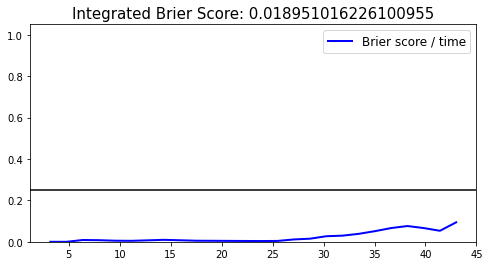

0.9676756352765321


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:437: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [9]:
from matplotlib import pyplot as plt
%pylab inline

pi, mu, std, survival_predictions, mlt = dws.prdict_survival(X_valid)
pi, mu, std, survival_predictions, mlt = pi.cpu(), mu.cpu(), std.cpu(), survival_predictions.cpu(), mlt.cpu().data.numpy()
survival_predictions = np.squeeze(survival_predictions.data.numpy())

brier_res, ibs, figure = dws.b_index(X_train.values, T_train, E_train.astype(float), X_valid.values, T_valid, E_valid.astype(float), survival_predictions.T, plot=True)
figure.show()
c_index = dws.c_index(mlt, T_valid, E_valid)
print(c_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:421: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:422: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



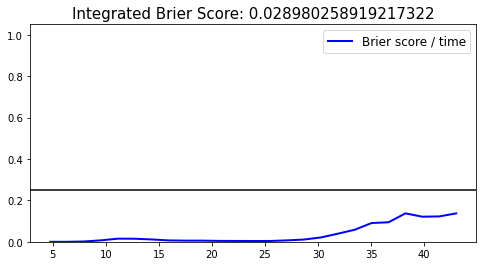

0.964595718552011


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:437: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [10]:
pi, mu, std, survival_predictions, mlt = dws.prdict_survival(X_test)
pi, mu, std, survival_predictions, mlt = pi.cpu(), mu.cpu(), std.cpu(), survival_predictions.cpu(), mlt.cpu().data.numpy()
survival_predictions = np.squeeze(survival_predictions.data.numpy())

brier_res, ibs, figure = dws.b_index(X_train.values, T_train, E_train.astype(float), X_test.values, T_test, E_test.astype(float), survival_predictions.T, plot=True)
figure.show()
c_index = dws.c_index(mlt, T_test, E_test)
print(c_index)

In [11]:
non_censored_diagn(data_test, E_test, T_test, mlt, 10).show()

In [ ]:
pd.DataFrame(data={'Event': E_test, 'True': T_test, 'PRED': mlt})

,Event,True,PRED
0,0,22.0,87.558716
1,0,13.0,144.769791
2,0,43.0,179.578903
3,1,31.0,33.426125
4,0,41.0,166.871582
...,...,...,...
625,0,44.0,157.729477
626,0,4.0,190.098206
627,0,35.0,181.357712
628,0,6.0,195.182205


In [16]:
idx = data_test.loc[(data_test[event_column]==1) & (data_test[time_column]>=25) & (data_test[time_column]<=30)].index.values
plot_surv(idx, T_test, mlt, survival_predictions, dws.times).show()

In [ ]:
imp = dws.feature_importance(10, X_test, T_test, E_test, batch_size=None)
fig = go.Figure()
for i in range(X_test.shape[1]):
    fig.add_trace(go.Box(x=imp['importances'][:, i], name=X_test.columns[i]))
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
fig.write_html("/content/drive/My Drive/Colab Notebooks/survival analysis/phoenix_employee_attrition/phoenix_data/feat_imp.html")

In [ ]:
surv = pd.DataFrame(survival_predictions)
times = pd.DataFrame(dws.times, columns=['Times'])
res = pd.concat((times, surv), 1)
data_test.to_csv('/content/drive/My Drive/Colab Notebooks/survival analysis/phoenix_employee_attrition/phoenix_data/test_data.csv', index=False)
res.to_csv('/content/drive/My Drive/Colab Notebooks/survival analysis/phoenix_employee_attrition/phoenix_data/surve_curve.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [ ]:
pi[127]

tensor([0.5385, 0.3855, 0.0760], grad_fn=<SelectBackward0>)

In [ ]:
mu

tensor([[ 3.8614,  0.9315,  3.2493],
        [ 1.3498, -1.0948,  2.3471],
        [ 0.3427, -0.0226,  1.5585],
        ...,
        [ 0.8125, -2.1283,  1.4230],
        [ 1.2591,  0.3586,  2.1618],
        [ 2.6449,  0.5053,  2.6158]], grad_fn=<ToCopyBackward0>)

In [ ]:
std

tensor([[5.6644e-03, 5.0308e+00, 5.9187e-03],
        [8.3047e-03, 9.7209e+00, 6.9053e-03],
        [2.7909e-03, 5.8262e+00, 4.4599e-03],
        ...,
        [4.1315e-03, 1.5953e+01, 3.0430e-03],
        [7.9955e-03, 3.6421e+00, 4.6699e-03],
        [5.7642e-03, 6.3993e+00, 4.3525e-03]], grad_fn=<ToCopyBackward0>)

In [ ]:
(np.exp(-1.0948 + 9.7209e+00**2 / 2))

1.106770754511773e+20